## Download dataset from Kaggle

In [2]:
# kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset
! kaggle competitions download -c dogs-vs-cats

dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


## Imports

In [3]:
import zipfile
import os

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

from utils import train_val, plot_losses

## Explore data

In [5]:
zip_ref = zipfile.ZipFile('dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
zip_ref = zipfile.ZipFile('train.zip', 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [7]:
zip_ref = zipfile.ZipFile('test1.zip', 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [8]:
len(os.listdir('./train/')), len(os.listdir('./test1/'))

(25000, 12500)

In [9]:
train_dir = './train/'
test_dir = './test1/'

In [10]:
train_df = pd.DataFrame({'image_path': [train_dir + x for x in os.listdir(train_dir)]})
train_df['label'] = train_df.image_path.apply(lambda x: x.split('/')[-1].split('.')[0])

In [11]:
train_df.head()

image_path label
0   ./train/dog.6186.jpg   dog
1   ./train/dog.5146.jpg   dog
2   ./train/cat.1981.jpg   cat
3   ./train/cat.4431.jpg   cat
4  ./train/dog.11606.jpg   dog

In [12]:
test_df = pd.DataFrame({'image_path': [test_dir + x for x in os.listdir(test_dir)]})
test_df['label'] = test_df.image_path.apply(lambda x: x.split('/')[-1].split('.')[0])

In [13]:
test_df.head()

image_path  label
0  ./test1/10172.jpg  10172
1    ./test1/993.jpg    993
2  ./test1/10524.jpg  10524
3   ./test1/8787.jpg   8787
4  ./test1/10740.jpg  10740

Don't need test, because we will not make a submission to Kaggle competition

In [14]:
train_df.label.value_counts()

dog    12500
cat    12500
Name: label, dtype: int64

## Create train and validation datasets/dataloaders

In [15]:
class DatasetCatsVsDogs(Dataset):
    def __init__(self, data_df, mode='train', transform = None) -> None:
        self.data_df = data_df
        self.mode = mode
        self.transform = transform
        
    def __len__(self):
        return self.data_df.shape[0]
    
    def __getitem__(self, idx):
        img = Image.open(self.data_df.image_path[idx])
        if self.transform is not None:
            img = self.transform(img)
        img = np.array(img)
            if self.mode == 'train':
                label = 1 if self.data_df.label[idx] == 'dog' else 0
                return img.astype('float32'), label
            else:
                return img.astype('float32')

In [16]:
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ColorJitter(),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(128),
    transforms.ToTensor()
])

In [17]:
# now split dataset into train and val
idx_train, idx_val = train_test_split(
    train_df.index.values, 
    stratify=train_df.label, 
    test_size = 0.25)
train_df_final = train_df.iloc[idx_train].reset_index(drop=True)
val_df_final = train_df.iloc[idx_val].reset_index(drop=True)

In [18]:
print('train labels')
print(train_df_final.size)
print(train_df_final.label.value_counts())
print('-'*10)
print('val labels')
print(val_df_final.size)
print(val_df_final.label.value_counts())

train labels
37500
dog    9375
cat    9375
Name: label, dtype: int64
----------
val labels
12500
dog    3125
cat    3125
Name: label, dtype: int64


In [19]:
ds_train = DatasetCatsVsDogs(train_df_final, transform=data_transform)
ds_val = DatasetCatsVsDogs(val_df_final, transform=data_transform)

dl_train = DataLoader(ds_train, batch_size=32, shuffle=True, num_workers=2)
dl_val = DataLoader(ds_val, batch_size=32, shuffle=True, num_workers=2)

Let's observe some examples from train

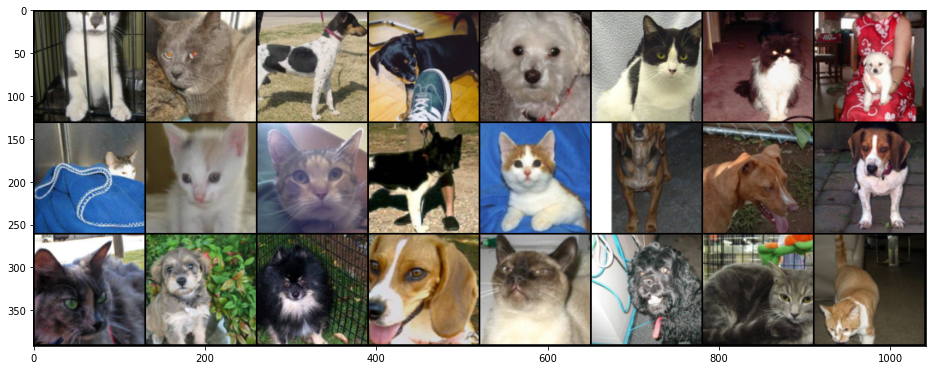

In [20]:
samples, labels = iter(dl_train).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

## Define model, add new classification layer and train it

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [22]:
model = torchvision.models.resnet34(pretrained=True)

num_ftrs = model.fc.in_features
emb_size = 500
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, emb_size),
    nn.Linear(emb_size, 2),
)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, amsgrad=True)

scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, 
    milestones=[500,1000,1500], 
    gamma=0.5
    )

*Note*: we are using sheduler for learning rate so it would change during training to achieve better convergence

In [24]:
%%time
epochs = 15
loss_train, loss_val = train_val(model, dl_train, dl_val, epochs, criterion, 
                                 optimizer, scheduler, device)

Epoch 1/15


100%|██████████| 196/196 [00:31<00:00,  6.27it/s]


Train mean loss: 0.6261197047581445 , Val mean loss: 0.7203032404792552
Classwise accuracy:
Class 0 - 0.4496, Class 1 - 0.54496
              precision    recall  f1-score   support

           0       0.50      0.45      0.47      3125
           1       0.50      0.54      0.52      3125

    accuracy                           0.50      6250
   macro avg       0.50      0.50      0.50      6250
weighted avg       0.50      0.50      0.50      6250

----------------------------------------
Epoch 2/15


100%|██████████| 196/196 [00:31<00:00,  6.25it/s]


Train mean loss: 0.3318114833073506 , Val mean loss: 0.6871429234743118
Classwise accuracy:
Class 0 - 0.59616, Class 1 - 0.47168
              precision    recall  f1-score   support

           0       0.53      0.60      0.56      3125
           1       0.54      0.47      0.50      3125

    accuracy                           0.53      6250
   macro avg       0.53      0.53      0.53      6250
weighted avg       0.53      0.53      0.53      6250

----------------------------------------
Epoch 3/15


100%|██████████| 196/196 [00:31<00:00,  6.16it/s]


Train mean loss: 0.19575165859312327 , Val mean loss: 0.2491246921257401
Classwise accuracy:
Class 0 - 0.89216, Class 1 - 0.89376
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      3125
           1       0.89      0.89      0.89      3125

    accuracy                           0.89      6250
   macro avg       0.89      0.89      0.89      6250
weighted avg       0.89      0.89      0.89      6250

----------------------------------------
Epoch 4/15


100%|██████████| 196/196 [00:32<00:00,  6.10it/s]


Train mean loss: 0.15767256439736577 , Val mean loss: 0.23429078897651362
Classwise accuracy:
Class 0 - 0.8992, Class 1 - 0.89856
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      3125
           1       0.90      0.90      0.90      3125

    accuracy                           0.90      6250
   macro avg       0.90      0.90      0.90      6250
weighted avg       0.90      0.90      0.90      6250

----------------------------------------
Epoch 5/15


100%|██████████| 196/196 [00:31<00:00,  6.19it/s]


Train mean loss: 0.13206211636923634 , Val mean loss: 0.18322238784606512
Classwise accuracy:
Class 0 - 0.92928, Class 1 - 0.91392
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      3125
           1       0.93      0.91      0.92      3125

    accuracy                           0.92      6250
   macro avg       0.92      0.92      0.92      6250
weighted avg       0.92      0.92      0.92      6250

----------------------------------------
Epoch 6/15


100%|██████████| 196/196 [00:31<00:00,  6.24it/s]


Train mean loss: 0.11525751612985144 , Val mean loss: 0.1793138462555956
Classwise accuracy:
Class 0 - 0.92704, Class 1 - 0.91872
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      3125
           1       0.93      0.92      0.92      3125

    accuracy                           0.92      6250
   macro avg       0.92      0.92      0.92      6250
weighted avg       0.92      0.92      0.92      6250

----------------------------------------
Epoch 7/15


100%|██████████| 196/196 [00:31<00:00,  6.22it/s]


Train mean loss: 0.10653653766867727 , Val mean loss: 0.18367931639243448
Classwise accuracy:
Class 0 - 0.92224, Class 1 - 0.92096
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      3125
           1       0.92      0.92      0.92      3125

    accuracy                           0.92      6250
   macro avg       0.92      0.92      0.92      6250
weighted avg       0.92      0.92      0.92      6250

----------------------------------------
Epoch 8/15


100%|██████████| 196/196 [00:31<00:00,  6.28it/s]


Train mean loss: 0.09295276742199683 , Val mean loss: 0.16583949868206163
Classwise accuracy:
Class 0 - 0.93088, Class 1 - 0.93184
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      3125
           1       0.93      0.93      0.93      3125

    accuracy                           0.93      6250
   macro avg       0.93      0.93      0.93      6250
weighted avg       0.93      0.93      0.93      6250

----------------------------------------
Epoch 9/15


100%|██████████| 196/196 [00:31<00:00,  6.25it/s]


Train mean loss: 0.08714380497494299 , Val mean loss: 0.1461933745660496
Classwise accuracy:
Class 0 - 0.93792, Class 1 - 0.9376
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      3125
           1       0.94      0.94      0.94      3125

    accuracy                           0.94      6250
   macro avg       0.94      0.94      0.94      6250
weighted avg       0.94      0.94      0.94      6250

----------------------------------------
Epoch 10/15


100%|██████████| 196/196 [00:31<00:00,  6.30it/s]


Train mean loss: 0.07943470668764435 , Val mean loss: 0.13919330439150182
Classwise accuracy:
Class 0 - 0.94016, Class 1 - 0.94016
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      3125
           1       0.94      0.94      0.94      3125

    accuracy                           0.94      6250
   macro avg       0.94      0.94      0.94      6250
weighted avg       0.94      0.94      0.94      6250

----------------------------------------
Epoch 11/15


100%|██████████| 196/196 [00:31<00:00,  6.14it/s]


Train mean loss: 0.0728897665501747 , Val mean loss: 0.13424388481760208
Classwise accuracy:
Class 0 - 0.94176, Class 1 - 0.94368
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      3125
           1       0.94      0.94      0.94      3125

    accuracy                           0.94      6250
   macro avg       0.94      0.94      0.94      6250
weighted avg       0.94      0.94      0.94      6250

----------------------------------------
Epoch 12/15


100%|██████████| 196/196 [00:34<00:00,  5.64it/s]


Train mean loss: 0.06783986270170239 , Val mean loss: 0.11619780071516883
Classwise accuracy:
Class 0 - 0.9536, Class 1 - 0.95296
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3125
           1       0.95      0.95      0.95      3125

    accuracy                           0.95      6250
   macro avg       0.95      0.95      0.95      6250
weighted avg       0.95      0.95      0.95      6250

----------------------------------------
Epoch 13/15


100%|██████████| 196/196 [00:32<00:00,  5.99it/s]


Train mean loss: 0.06650291896884492 , Val mean loss: 0.12690866645069185
Classwise accuracy:
Class 0 - 0.94208, Class 1 - 0.9472
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      3125
           1       0.94      0.95      0.94      3125

    accuracy                           0.94      6250
   macro avg       0.94      0.94      0.94      6250
weighted avg       0.94      0.94      0.94      6250

----------------------------------------
Epoch 14/15


100%|██████████| 196/196 [00:32<00:00,  6.10it/s]


Train mean loss: 0.06187402529569673 , Val mean loss: 0.10803667704897876
Classwise accuracy:
Class 0 - 0.9568, Class 1 - 0.96032
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3125
           1       0.96      0.96      0.96      3125

    accuracy                           0.96      6250
   macro avg       0.96      0.96      0.96      6250
weighted avg       0.96      0.96      0.96      6250

----------------------------------------
Epoch 15/15


100%|██████████| 196/196 [00:31<00:00,  6.14it/s]

Train mean loss: 0.057440353341026346 , Val mean loss: 0.10786187958224125
Classwise accuracy:
Class 0 - 0.95776, Class 1 - 0.95552
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3125
           1       0.96      0.96      0.96      3125

    accuracy                           0.96      6250
   macro avg       0.96      0.96      0.96      6250
weighted avg       0.96      0.96      0.96      6250

----------------------------------------
CPU times: user 9min 48s, sys: 36.9 s, total: 10min 25s
Wall time: 31min 44s


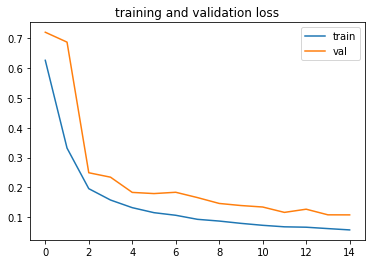

In [25]:
plot_losses(loss_train, loss_val)

Let's observe some pictures which we have got wrong

In [26]:
img_false_pred = []
title = []
model.eval()
for data, label in tqdm(dl_val):
    data, label = data.to(device), label.to(device)
    pred = torch.argmax(model(data), dim=1).cpu().numpy()
    idx_false = np.arange(len(pred))[label.cpu().numpy() != pred]
    img_false_pred += list(data.cpu().numpy()[idx_false])
    title += list(pred[idx_false])

100%|██████████| 196/196 [00:28<00:00,  6.80it/s]


In [27]:
len(img_false_pred)

164

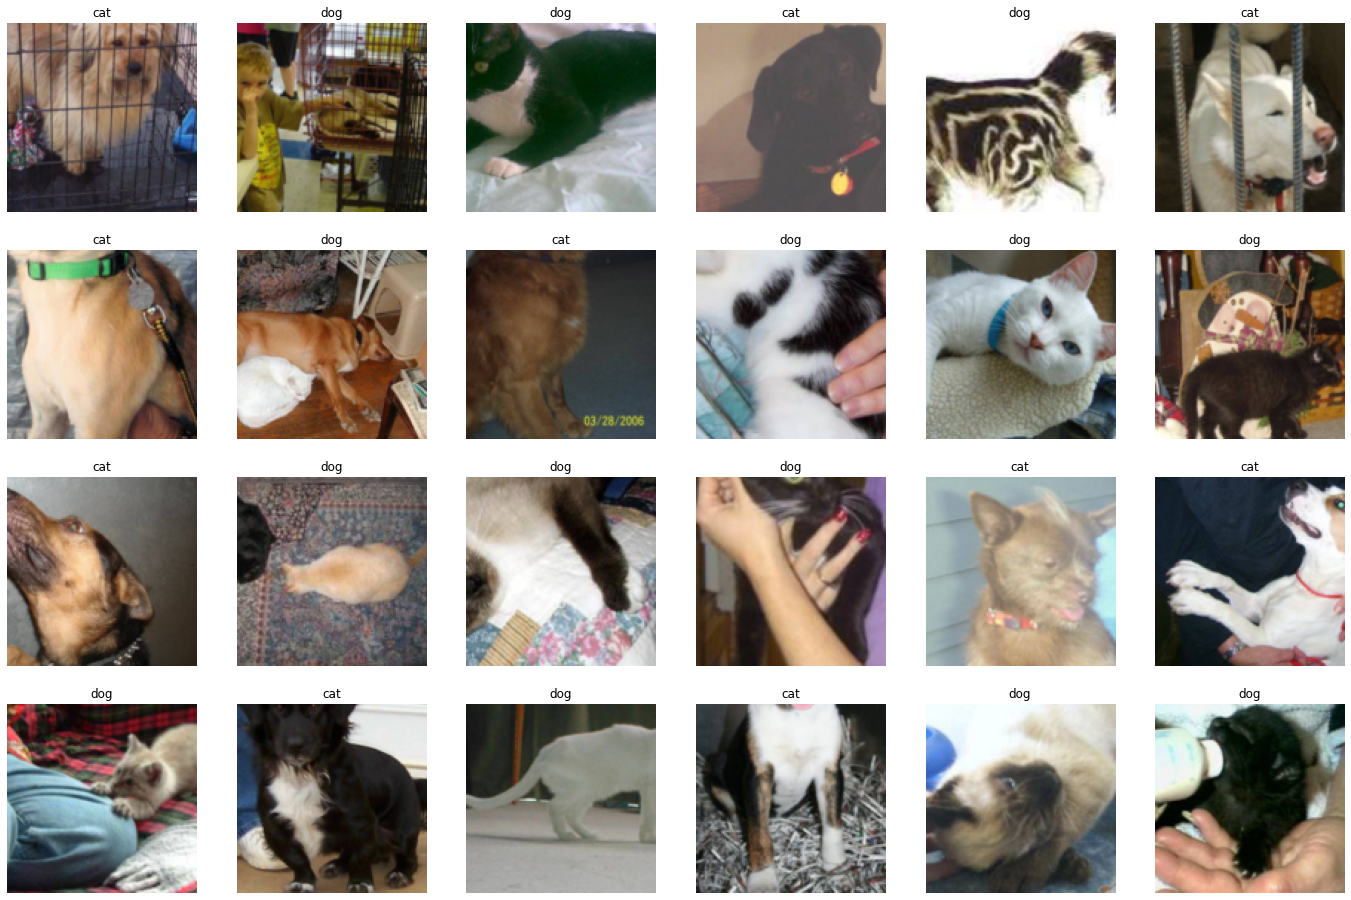

In [28]:
fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
ad = {0:'cat', 1:'dog'}
for num, sample in enumerate(img_false_pred[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[title[num]])
    plt.axis('off')
    plt.imshow(np.transpose(sample, (1,2,0)))

## Finally, predict unlabeled data

In [29]:
data_transform_test = transforms.Compose(
    [
     transforms.Resize(256),
     transforms.RandomCrop(224),
     transforms.Resize(128),
     transforms.ToTensor()
    ]
)
ds_test = DatasetCatsVsDogs(test_df, transform=data_transform_test)

dl_test = DataLoader(ds_test, batch_size=32, shuffle=True, num_workers=2)

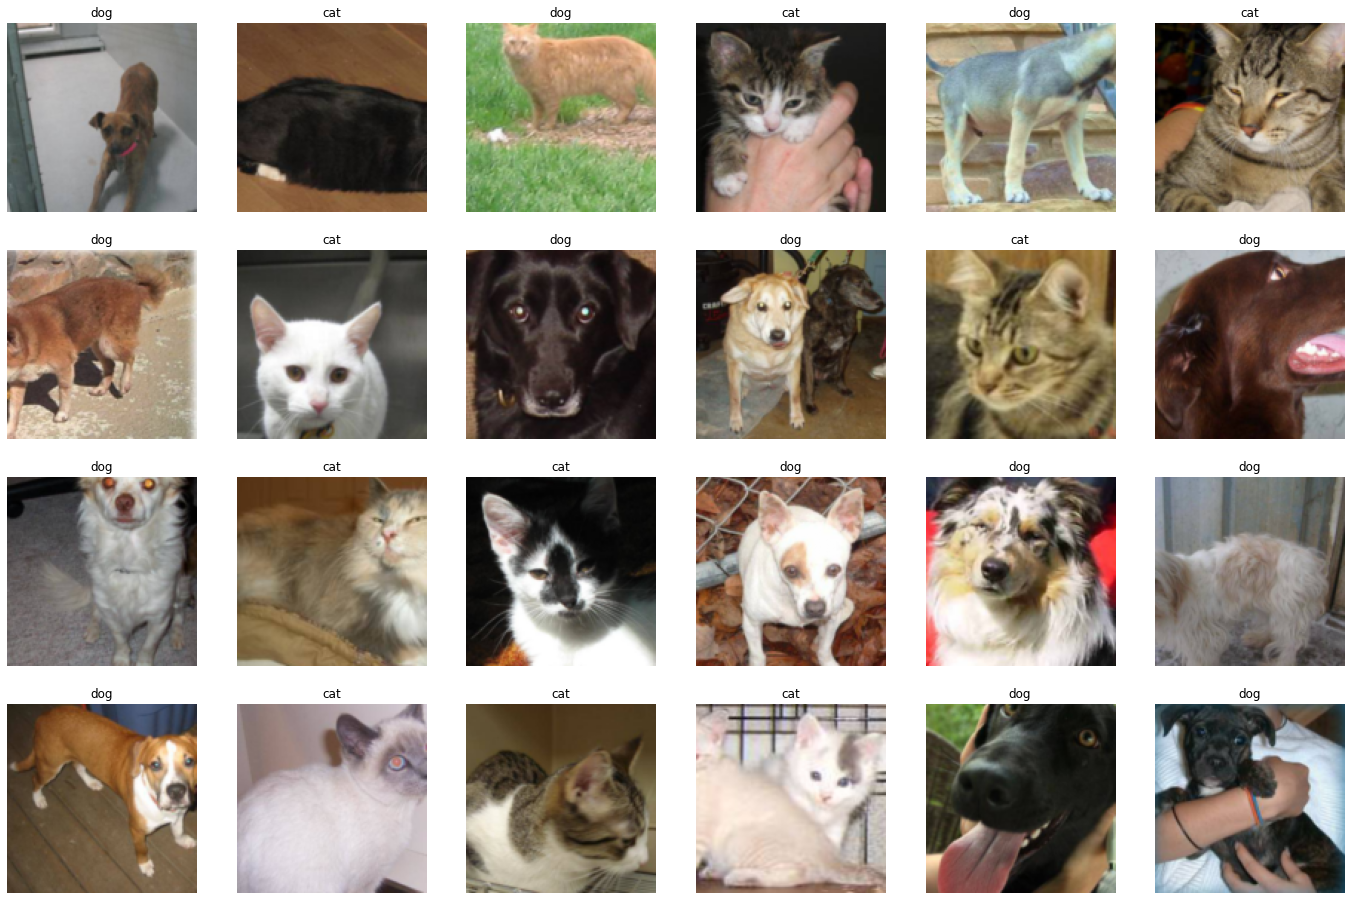

In [30]:
samples, _ = iter(dl_test).next()
samples = samples.to(device)
fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}
for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))